In this tutorial we explore the **Great Expectations** Python package which allows us to create a set of expectations for our datasets and automating data quality checks.

The tutorial was inspired on [this guide](https://legacy.docs.greatexpectations.io/en/latest/guides/tutorials/quick_start.html). For information check the [official documentation](https://docs.greatexpectations.io/docs/).

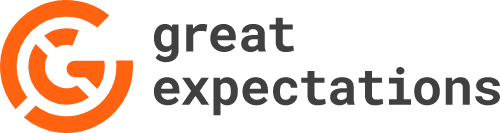

# Package imports

In [1]:
import pandas as pd
import json
import great_expectations as gx

# Loading data

Similarly to what we do with Pandas, `pd.read_csv()`, we can do `gx.read_csv`. Wrapped versions of other Pandas methods  such as `read_excel` or `read_parquet` are also available. You can also work with databases and Spark.

In [2]:
titanic = gx.read_csv("titanic.csv")

Alternatively we can read a CSV with pandas and transform the `DataFrame` into a `PandasDataset`. The two classes are identical, except that `PandasDataset` has access to Great Expectations’ methods.

In [3]:
titanic = pd.read_csv("titanic.csv")

type(titanic)

In [4]:
titanic = gx.from_pandas(
    titanic
)
type(titanic)

In [5]:
titanic.head()

# Different types of expectations

- You can find a glossary of expectations [here](https://legacy.docs.greatexpectations.io/en/latest/reference/glossary_of_expectations.html#expectation-glossary)
    - Table shape
    - Missing values, unique values, and types
    - Sets and ranges
    - String matching
    - Datetime and JSON parsing
    - Aggregate functions
    - Multi-column
    - Distributional functions
    - FileDataAsset
- You can also create your own expectations. See how to [here](https://docs.greatexpectations.io/docs/guides/expectations/creating_custom_expectations/overview)

### Columns in your dataset

In [6]:
titanic.expect_table_columns_to_match_set(column_set=['passenger_id', 'survived', 'pclass', 'sex', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town',
       'alive', 'alone'], exact_match = True)

### Columns with unique values

In [7]:
titanic.expect_column_values_to_be_unique(column='passenger_id')["success"]

### No missing values

We make use of the `mostly` argument when our expectation only applies to a certain percentage of the dataset.

In [8]:
titanic.expect_column_values_to_not_be_null("passenger_id")["success"]

In [9]:
titanic.expect_column_values_to_not_be_null("age")["success"]

In [10]:
titanic.expect_column_values_to_not_be_null("age", mostly=0.80)["success"]

### Column values are a set of categories

In [11]:
titanic["sex"].unique()

In [12]:
titanic.expect_column_values_to_be_in_set(column ="sex", value_set =["male", "female"])["success"]

### Range of values in column

In [13]:
titanic.expect_column_values_to_be_between(column='age', max_value=100, min_value=0, strict_min=False, strict_max=False)["success"]

# Duplicate expectations

The latest expectation to be ran is the one that's accounted for and it will replace any older ones. Hence, we never have conflicting expectations.

In [14]:
len(titanic)

In [15]:
titanic.expect_table_row_count_to_equal(1000)

In [16]:
titanic.expect_table_row_count_to_equal(891)

# Adding notes or metadata

Might be useful to add metadata to your expectations, in case they are based on a previous analysis you did or on domain expertise.

In [17]:
titanic.expect_column_values_to_be_between(column='fare',
                                      max_value=515,
                                      min_value=0,
                                      strict_min=True, 
                                      strict_max=False,
                                      meta = {
        "notes": {
           "content": ["Based on our domain expertise. For more information look at resource X." ],
           "format": "markdown",
           "source": "Nesta UK"
        }
                                      }
   )


# Creating an expectation suite

The `PandasDataset` object will build up a list of Expectations, as you apply the different `df.expect_*`. After defining all your expectations, you can get a dictionary of configurations for your Expectations by running the line below, which returns an object of type `ExpectationSuite`.



In [18]:
titanic.get_expectation_suite()

In [19]:
titanic.get_expectation_suite()["expectations"]

In [20]:
titanic.get_expectation_suite()["expectations"][0]

In the process of creating your suite of expectations, you can choose not to discard any failed expectations (which by default you do):

In [21]:
titanic.get_expectation_suite(discard_failed_expectations=False)

In [22]:
titanic.get_expectation_suite(discard_failed_expectations=False)["expectations"][-1]

# Saving your expectation suite
You can save your expectations suite as a json file.

In [23]:
with open("titanic_expectations_suite.json", "w") as my_file:
    my_file.write(
        json.dumps(titanic.get_expectation_suite().to_json_dict(),sort_keys=True, indent=4)
    )

# Validating expectations on a different set

The expectations suite json file can then be used for validating a new data batch, account for changes in the same batch sent my partners in multiple times, etc.

In the example below we make some changes to the original dataset and validate our suite of expectations. As expectated, a couple of them fail!

Changes to the dataset:

In [24]:
titanic_2 = titanic.copy()

In [25]:
titanic_2["passenger_id"].iloc[0] = 2
titanic_2["age"].iloc[1] = 200

In [26]:
titanic_2

Validating the new dataset on the expectations:

In [27]:
validation_results = titanic_2.validate(
    expectation_suite="titanic_expectations_suite.json"
)


The validation results:

In [28]:
validation_results

In [29]:
validation_results["results"]